In [1]:
import sys
sys.path.insert(0, sys.path[0].removesuffix('/src/jupyter_nb'))
from datetime import datetime

import src.utils as utils
import src.myenv as myenv
import src.calcEMA as calc_utils

import numpy as np
import pandas as pd

from pycaret.classification import ClassificationExperiment
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

<built-in method __dir__ of sqlite3.Connection object at 0x7f65b1332740>


In [2]:
data = utils.get_data(symbol="BTCUSDT", interval="1h", columns=myenv.all_cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55839 entries, 2017-08-17 04:00:00 to 2024-01-05 02:00:00
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     55839 non-null  datetime64[ns]
 1   open                          55839 non-null  float32       
 2   high                          55839 non-null  float32       
 3   low                           55839 non-null  float32       
 4   close                         55839 non-null  float32       
 5   volume                        55839 non-null  float32       
 6   close_time                    55839 non-null  int64         
 7   quote_asset_volume            55839 non-null  float32       
 8   number_of_trades              55839 non-null  int16         
 9   taker_buy_base_asset_volume   55839 non-null  float32       
 10  taker_buy_quote_asset_volume  55839 non-null  float32      

In [3]:
# fix_imbalance_method: condensednearestneighbour, editednearestneighborus, repeatededitednearestneighbours, allknn, instancehardnessthreshold, nearmiss, neighbourhoodcleaningrule, onesidedselection, randomundersampler, tomeklinks, randomoversampler, smote, smotenc, smoten, adasyn, borderlinesmote, kmeanssmote, svmsmote, smoteenn, smotetomek.
imbalance = 'smoteenn'#'smoten','smote','smoteenn'
p_ema = 250
min_rsi = 30
max_rsi = 70
max_rolling_periods = 6
target_margin = 1.5
train_size = 0.9

data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")
data["amplitude"] = ((data["high"] - data["low"]) / data["low"]) * 100
data["change_open_close"] = ((data["close"] - data["open"]) / data["open"]) * 100
data = calc_utils.calc_ema_periods(
    data, periods_of_time=[i for i in range(50, 250 + 1, 25)]
)
data = calc_utils.calc_RSI(data)

data['close_max'] = data['close'].rolling(max_rolling_periods).max()
data.dropna(inplace=True)
data['result'] = ((data['close_max'] - data['close']) / data['close']) * 100
data[myenv.label] = np.where(data['result'] >= target_margin, 'LONG', 'ESTAVEL')

data.drop(columns=['close_max', 'result'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55590 entries, 2017-08-27 13:00:00 to 2024-01-05 02:00:00
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     55590 non-null  datetime64[ns]
 1   open                          55590 non-null  float32       
 2   high                          55590 non-null  float32       
 3   low                           55590 non-null  float32       
 4   close                         55590 non-null  float32       
 5   volume                        55590 non-null  float32       
 6   close_time                    55590 non-null  datetime64[ns]
 7   quote_asset_volume            55590 non-null  float32       
 8   number_of_trades              55590 non-null  int16         
 9   taker_buy_base_asset_volume   55590 non-null  float32       
 10  taker_buy_quote_asset_volume  55590 non-null  float32      

In [4]:
data.groupby(myenv.label)['open_time'].count()

status
ESTAVEL    47257
LONG        8333
Name: open_time, dtype: int64

In [5]:
train_data = data.iloc[:int(len(data) * train_size)]
validation_data = data.iloc[train_data.shape[0]:]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50031 entries, 2017-08-27 13:00:00 to 2023-05-18 11:00:00
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     50031 non-null  datetime64[ns]
 1   open                          50031 non-null  float32       
 2   high                          50031 non-null  float32       
 3   low                           50031 non-null  float32       
 4   close                         50031 non-null  float32       
 5   volume                        50031 non-null  float32       
 6   close_time                    50031 non-null  datetime64[ns]
 7   quote_asset_volume            50031 non-null  float32       
 8   number_of_trades              50031 non-null  int16         
 9   taker_buy_base_asset_volume   50031 non-null  float32       
 10  taker_buy_quote_asset_volume  50031 non-null  float32      

In [6]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5559 entries, 2023-05-18 12:00:00 to 2024-01-05 02:00:00
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     5559 non-null   datetime64[ns]
 1   open                          5559 non-null   float32       
 2   high                          5559 non-null   float32       
 3   low                           5559 non-null   float32       
 4   close                         5559 non-null   float32       
 5   volume                        5559 non-null   float32       
 6   close_time                    5559 non-null   datetime64[ns]
 7   quote_asset_volume            5559 non-null   float32       
 8   number_of_trades              5559 non-null   int16         
 9   taker_buy_base_asset_volume   5559 non-null   float32       
 10  taker_buy_quote_asset_volume  5559 non-null   float32       

In [7]:
numeric_features = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'amplitude',
                    'change_open_close', 'ema_50p', 'ema_50p_diff', 'ema_75p', 'ema_75p_diff', 'ema_100p', 'ema_100p_diff', 'ema_125p', 'ema_125p_diff', 'ema_150p', 'ema_150p_diff', 'ema_175p',
                    'ema_175p_diff', 'ema_200p', 'ema_200p_diff', 'ema_225p', 'ema_225p_diff', 'ema_250p', 'ema_250p_diff', 'rsi']
date_features = ['open_time', 'close_time']


ce = ClassificationExperiment()
setup = ce.setup(data=train_data,
                 train_size=0.9,
                 target=myenv.label,
                 numeric_features=numeric_features,
                 date_features=date_features,
                 create_date_columns=["hour", "day", "month"],
                 data_split_shuffle=False,
                 data_split_stratify=False,
                 fix_imbalance=True,
                 fix_imbalance_method=imbalance,
                 feature_selection=True,
                 feature_selection_estimator='lightgbm',
                 remove_outliers=True,
                 fold_strategy='timeseries',
                 fold=3,
                 session_id=123,
                 normalize=True,
                 use_gpu=True,
                 verbose=False,
                 n_jobs=-1)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [8]:
# model = setup.compare_models(exclude = ['ransac', 'huber', 'par', 'ada', 'omp', 'llar'])
model = setup.create_model('gbc') # 'gbc' 'xgboost' 'lightgbm'
estimator = setup.pull().index[0]
print(f'Best Model Estimator: {estimator}')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8539,0.9159,0.8539,0.9045,0.8703,0.4914,0.5219
1,0.8049,0.9215,0.8049,0.8852,0.8253,0.4990,0.5463
2,0.8179,0.9090,0.8179,0.8848,0.8373,0.4819,0.5190
Mean,0.8255,0.9155,0.8255,0.8915,0.8443,0.4908,0.5291
Std,0.0207,0.0051,0.0207,0.0092,0.0191,0.0070,0.0122


Best Model Estimator: 0


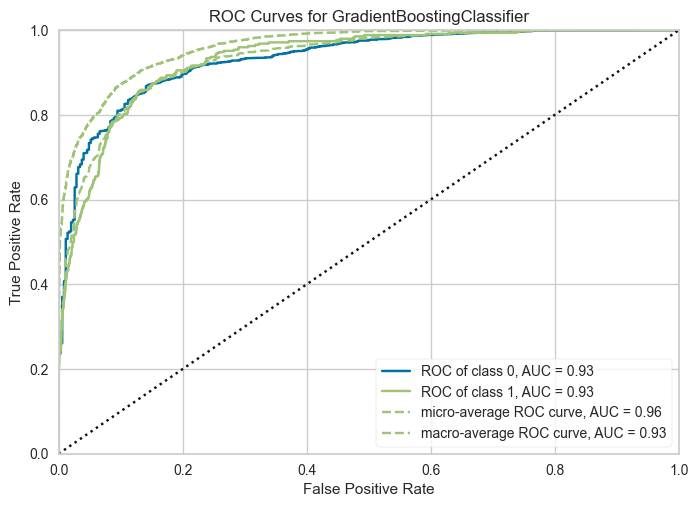

In [9]:
fig = setup.plot_model(model)

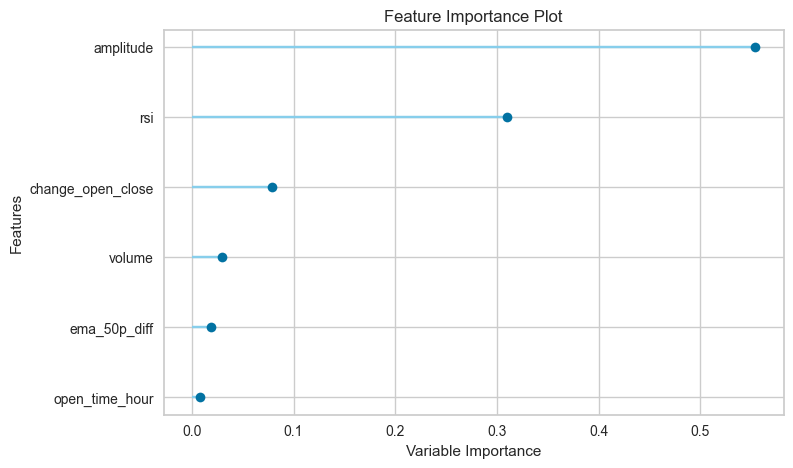

In [10]:
fig = setup.plot_model(model, plot = 'feature')

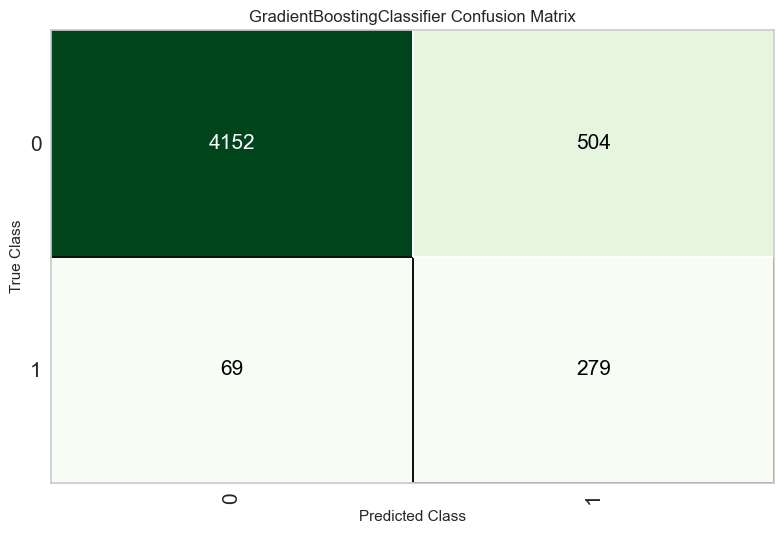

In [11]:
fig = setup.plot_model(model, plot = 'confusion_matrix')

In [12]:
holdout_pred = setup.predict_model(model)
holdout_pred['_score'] = holdout_pred[myenv.label] == holdout_pred['prediction_label']
holdout_pred.groupby(myenv.label)['_score'].mean()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8855,0.9327,0.8855,0.9400,0.9047,0.4394,0.4856


status
ESTAVEL    0.891753
LONG       0.801724
Name: _score, dtype: float64

In [13]:
#model = setup.tune_model(model)
#holdout_pred = setup.predict_model(model)
#holdout_pred['_score'] = holdout_pred[myenv.label] == holdout_pred['prediction_label']
#holdout_pred.groupby(myenv.label)['_score'].mean()

In [14]:
predictions = setup.predict_model(model, data=validation_data.drop(columns=[myenv.label], errors='ignore'))
df_score = predictions[['prediction_label', 'prediction_score']]
df_score = pd.concat([validation_data[myenv.label], df_score], axis=1)
df_score['_score'] = df_score[myenv.label] == df_score['prediction_label']
df_score.groupby(myenv.label)['_score'].mean()

status
ESTAVEL    0.946724
LONG       0.761134
Name: _score, dtype: float64

In [15]:
final_model = setup.finalize_model(model)

In [16]:
predictions = setup.predict_model(final_model, data=validation_data.drop(columns=[myenv.label], errors='ignore'))
df_score = predictions[['prediction_label', 'prediction_score']]
df_score = pd.concat([validation_data[myenv.label], df_score], axis=1)
df_score['_score'] = df_score[myenv.label] == df_score['prediction_label']
df_score.groupby(myenv.label)['_score'].mean()

status
ESTAVEL    0.948795
LONG       0.761134
Name: _score, dtype: float64

<code>
# GBC<br>
* status<br>
* ESTAVEL    0.886186<br>
* LONG       0.760200<br>
* Name: _score, dtype: float64<br>
<br>
<br>
</code>
<code>
# xgboost<br>
* status <br>
* ESTAVEL    0.869665<br>
* LONG       0.781016<br>
* Name: _score, dtype: float64<br>
<br>
<br>
</code>
<code>
# LightGBM<br>
* status<br>
ESTAVEL    0.863928<br>
LONG       0.785179<br>
Name: _score, dtype: float64<br>
</code>

